# Отчет 
## Графовые нейронные сети на базе слов для решения задачи Page Layout Analysis

**Задача**: Кратко сформулировать, какую проблему решает новая архитектура.

**Гипотеза**: Какие предположения лежат в основе нового подхода?

**Ожидания**: Какие улучшения предполагаются (скорость, точность, устойчивость и т. д.)?


Нужно где-то сказать про GLAM, и что она решает две задачи.

### Метрика качества
- F1 @ WordIoU [0.5, 0.95]
- mAP @ IoU [0.50:0.95]
- time

$$WordIoU = \frac{WordI}{WordU}$$

$WordI$-число слов в пересекающейся области

$WordU$-число слов в объединенной области

# Текущая SOTA на данных метриках (200 из val publaynet) 

|model|F1 WordIoU 0.50/0.95 | mAP @IoU [0.50:0.95] | time (file/sec)|
|-----|---------------------|----------------------|----------------|
| VGT |0.9985/0.8613        | 0.8713               |0.5792


# Локальные эксперименты
Локальные эксперименты проводятся на 1000 документах из train и нужны для качетсвенной оценки подходов

Тестирование серий происходит на 50 файлах

In [30]:
import re
import matplotlib.pyplot as plt

def extract_metrics_from_file(file_content):
    """
    Извлекает метрики F1 (IoU=0.50 и IoU=0.95), mAP и время из текста файла.
    
    Args:
        file_content (str): Содержимое файла с метриками.
    
    Returns:
        dict: Словарь с извлеченными метриками.
            {
                "F1_0.50": float,
                "F1_0.95": float,
                "mAP": float,
                "time": float
            }
    """
    metrics = {
        "F1_0.50": None,
        "F1_0.95": None,
        "mAP": None,
        "time": None
    }
    
    # Извлекаем F1 (IoU=0.50)
    f1_50_match = re.search(r"F1 \(IoU=0\.50\):\s+([0-9.]+)", file_content)
    if f1_50_match:
        metrics["F1_0.50"] = float(f1_50_match.group(1))
    
    # Извлекаем F1 (IoU=0.95)
    f1_95_match = re.search(r"F1 \(IoU=0\.95\):\s+([0-9.]+)", file_content)
    if f1_95_match:
        metrics["F1_0.95"] = float(f1_95_match.group(1))
    
    # Извлекаем mAP
    map_match = re.search(r"mAP@IoU\[0\.50:0\.95\]\s*=\s*([0-9.]+)", file_content)
    if map_match:
        metrics["mAP"] = float(map_match.group(1))
    
    # Извлекаем время
    time_match = re.search(r"mean time:\s+([0-9.]+)\s*sec", file_content)
    if time_match:
        metrics["time"] = float(time_match.group(1))
    
    return metrics

def read_res_test(header, name):
    with open(f'{header}/{name}/test_result.txt') as f:
         return extract_metrics_from_file(f.read())

### Exp 1. (balans)
Число классов в данных не равномерное. Это относится как к классификации, так и сегментации. Первый эксперимент направлен на выявление значимости балансировки.



In [31]:
print("exp \t F1_0.50 \t F1_0.95 \t mAP")
for obj in ['01_no', '02_yes', '03_heuristics']:
    print(obj if len(obj) <7 else obj[:7], end='\t')
    r = read_res_test('exp_01_balans', obj)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')

exp 	 F1_0.50 	 F1_0.95 	 mAP
01_no	0.07490637	0.05992509	0.00448294
02_yes	0.4726776	0.28688525	0.05417707
03_heur	0.40978593	0.25076453	0.03784199


### Exp 2. (Edge loss + Node loss)
Исходная модель направлена на решение сразу двух задач. Из архитектуры видно, что задача классификации решается раньше сегментации. Поэтому возникает вопрос, а если решать задачу только сегментации, необходимо ли включать в функцию потерь составляющую для классификации и если да, то в каком соотношение с loss для сегментации.

$$Loss=\alpha Loss_{node} + (1-\alpha) Loss_{edge}$$

exp 	 F1_0.50 F1_0.95 mAP
01_005	0.1796	0.1036	0.0089
02_025	0.3462	0.1978	0.0333
03_050	0.4192	0.2620	0.0441
04_075	0.4727	0.2869	0.0538
05_085	0.4620	0.2822	0.0522
06_095	0.3946	0.2362	0.0402
07_100	0.0048	0.0009	0.0000


Text(0.5, 0, 'a')

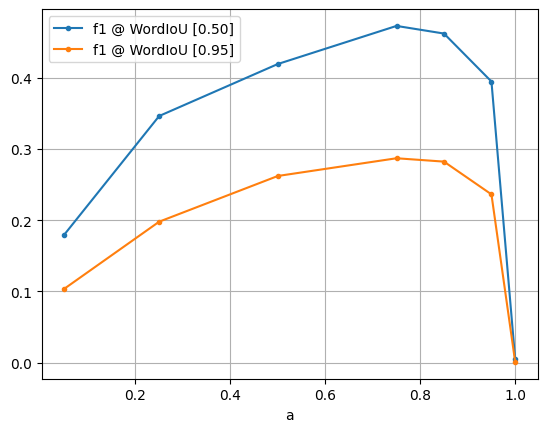

In [32]:

rez = []
t = [0.05, 0.25, 0.50, 0.75, 0.85, 0.95, 1.00]
print("exp \t F1_0.50 F1_0.95 mAP")
for obj in ['01_005', '02_025', '03_050', '04_075', '05_085', '06_095', '07_100']:
    print(obj, end='\t')
    r = read_res_test('exp_02_complex_loss', obj)
    print(f'{r['F1_0.50']:.4f}\t{r['F1_0.95']:.4f}\t{r['mAP']:.4f}')
    rez.append(r)

f1_50 = [float(r['F1_0.50']) for r in rez]
f1_95 = [float(r['F1_0.95']) for r in rez]

plt.grid()
plt.plot(t, f1_50, '.-', label="f1 @ WordIoU [0.50]")
plt.plot(t, f1_95, '.-',label="f1 @ WordIoU [0.95]")
plt.legend()
plt.xlabel('a')

### Exp 3-5. (count Tag и k-глубина)
В работе у слоев tag стоит k=3, варианты 1-6.
Число слоев может отличаться, поскольку слов в документе на много больше, чем строк.

In [36]:
def table2x2(exp, sub_exp, metric, di=[2, 5], dj =[2, 7]):
    print(metric+"-"*50)
    print("K:\t\t " + '\t'.join([f"{dii}" for dii in range(dj[0], dj[1])]), end="")
    for i in range(di[0], di[1]):
        print(f"\ncount tag {i}:", end="\t")
        for j in range(dj[0], dj[1]):
            try:
                r = read_res_test(exp,sub_exp(i, j))
                print(f'{r[metric]:.4f}', end="\t")
            except:
                print("   ", end="\t")
    print()

In [37]:
table2x2("exp_03_countTag_and_size_k", lambda i, j:  f"exp_{i}_kTag_{j}", "F1_0.50", di=[1, 6])
table2x2("exp_03_countTag_and_size_k", lambda i, j:  f"exp_{i}_kTag_{j}", "F1_0.95", di=[1, 6])
table2x2("exp_03_countTag_and_size_k", lambda i, j:  f"exp_{i}_kTag_{j}", "mAP", di=[1, 6])

F1_0.50--------------------------------------------------
K:		 2	3	4	5	6
count tag 1:	0.4412	0.4635	0.4000	0.3117	0.4412	
count tag 2:	0.4868	0.5139	0.4174	0.4189	0.4624	
count tag 3:	0.4180	0.4935	0.4249	0.4481	0.4385	
count tag 4:	0.5007	0.4831	0.4602	0.3709	0.3589	
count tag 5:	0.4274	0.4631	0.4506	0.4607	0.3292	
F1_0.95--------------------------------------------------
K:		 2	3	4	5	6
count tag 1:	0.2676	0.2833	0.2351	0.1591	0.2706	
count tag 2:	0.3255	0.3278	0.2703	0.2478	0.3006	
count tag 3:	0.2466	0.2655	0.2367	0.2711	0.2542	
count tag 4:	0.3105	0.2697	0.2836	0.1988	0.2147	
count tag 5:	0.2137	0.2894	0.2297	0.2775	0.1630	
mAP--------------------------------------------------
K:		 2	3	4	5	6
count tag 1:	0.0512	0.0574	0.0472	0.0204	0.0545	
count tag 2:	0.0649	0.0654	0.0538	0.0420	0.0540	
count tag 3:	0.0464	0.0592	0.0467	0.0549	0.0522	
count tag 4:	0.0653	0.0496	0.0618	0.0379	0.0374	
count tag 5:	0.0476	0.0604	0.0438	0.0608	0.0224	


In [40]:
table2x2("exp_04_countTag_and_size_k_big", lambda i, j:  f"exp_{i}_kTag_{j}", "F1_0.50", di=[1, 6], dj =[2, 6])
table2x2("exp_04_countTag_and_size_k_big", lambda i, j:  f"exp_{i}_kTag_{j}", "F1_0.95", di=[1, 6],dj =[2, 6])
table2x2("exp_04_countTag_and_size_k_big", lambda i, j:  f"exp_{i}_kTag_{j}", "mAP", di=[1, 6],dj =[2, 6])

F1_0.50--------------------------------------------------
K:		 2	3	4	5
count tag 1:	0.4595	0.4422	0.4211	0.3775	
count tag 2:	0.4162	0.4332	0.4609	0.4598	
count tag 3:	0.4401	0.4454	0.4231	0.3662	
count tag 4:	0.5257	0.4249	0.4090	0.4464	
count tag 5:	0.4036	0.3609	0.4370	0.4849	
F1_0.95--------------------------------------------------
K:		 2	3	4	5
count tag 1:	0.2861	0.2197	0.1925	0.1979	
count tag 2:	0.2365	0.2611	0.2788	0.2701	
count tag 3:	0.2580	0.2301	0.2396	0.2185	
count tag 4:	0.3457	0.2731	0.2418	0.2522	
count tag 5:	0.2458	0.2110	0.2779	0.2932	
mAP--------------------------------------------------
K:		 2	3	4	5
count tag 1:	0.0543	0.0546	0.0379	0.0449	
count tag 2:	0.0504	0.0478	0.0601	0.0478	
count tag 3:	0.0475	0.0503	0.0488	0.0486	
count tag 4:	0.0835	0.0486	0.0465	0.0551	
count tag 5:	0.0468	0.0314	0.0568	0.0623	


### Exp 5. (батч-нормализация)
В работе стоит две батч нормализации.Но может где-то она не нужна.

In [7]:
print("exp \t\t\t F1_0.50 \t F1_0.95 \t mAP")
for obj in ['01_node_no_edge_no', '02_node_yes_edge_no', '03_node_no_edge_yes', '04_node_yes_edge_yes']:
    print(obj, end='\t')
    r = read_res_test('exp_05_batchNorm', obj)
    r['k'] = i+1
    rez.append(r)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')

exp 			 F1_0.50 	 F1_0.95 	 mAP
01_node_no_edge_no	0.18816388	0.08497724	0.00931783
02_node_yes_edge_no	0.22994652	0.09090909	0.01277958
03_node_no_edge_yes	0.49184783	0.2826087	0.06082514
04_node_yes_edge_yes	0.4726776	0.28688525	0.05430273


### Exp (loss из 3-х компонент)
Верными являются ситуации:

- class 1 (id:0)  V   class 1 (id:0) # id - из какого блока  V-есть связь, X - нет связи
- class 1 (id:0)  X   class 1 (id:1)
- class 1 (id:0)  X   class 2 (id:1)

Не верные ситуации:
- class 1 (id:0)  X   class 1 (id:0)
- class 1 (id:0)  V   class 1 (id:1)
- class 1 (id:0)  V   class 2 (id:1)

т.е. сравниваются три ситуации:
- когда класс один и тот же и блоки из одного (истинная связь в этом случае равна 1)
- когда классы разные (тут классы просто разные)
- когда класс один, но не из одного блока (истинная связь в этом случае равна 0, а классы блоков совпадают)

Какая ошибка более важна требует эксперимент

In [6]:
print("exp \t\t F1_0.50 \t  F1_0.95 \t mAP")
rez = []
for i, obj in enumerate(['00_00_10', '00_10_00', '10_00_00', '00_05_05', '05_05_00', '05_00_05', '03_03_03']):
    print(obj, end='\t')
    r = read_res_test('exp_07_3loss_edge', obj)
    r['k'] = i+1
    rez.append(r)
    print(f'{r['F1_0.50']}\t{r['F1_0.95'] }\t{r['mAP']}')

exp 		 F1_0.50 	  F1_0.95 	 mAP
00_00_10	0.00450136	0.00107779	0.0
00_10_00	0.30206677	0.16216216	0.02548101
10_00_00	0.03065134	0.01532567	0.0024615
00_05_05	0.48907104	0.27868852	0.05671298
05_05_00	0.1598579	0.07460036	0.01015048
05_00_05	0.11615245	0.0508167	0.00517944
03_03_03	0.29042904	0.17491749	0.02387258


# Plot Document

In [41]:
import os
import matplotlib.pyplot as plt
os.environ['DEVICE'] = "cpu"
# os.environ['JAR_PDF_PARSER'] = '../../java/ispras_tbl_extr.jar'
import importlib
import matplotlib.pyplot as plt
from pager.page_model.sub_models.converters import PDF2Img
from pager.page_model.sub_models.pdf_model import PDFModel
from pager.page_model.sub_models.image_model import ImageModel
from pager.page_model.sub_models.dtype import ImageSegment


EXPERIMENT = "exp_00_base"
EXPERIMENT = "exp_04_countTag_and_size_k_big/exp_4_kTag_2"
exp = importlib.import_module(f"{'.'.join(EXPERIMENT.split('/'))}")

TorchModel = exp.TorchModel
GLAM_MODEL = os.path.join(EXPERIMENT, os.environ["GLAM_MODEL"])
LOG_FILE = os.path.join(EXPERIMENT, "log.txt")

def get_final_model():
    conf = exp.EXPERIMENT_PARAMS
    conf['path_model'] = GLAM_MODEL
    return exp.get_img2phis(conf)

model = get_final_model()
pdf = PDFModel()
img = ImageModel()
pdf2img = PDF2Img()

def plot_file(path_pdf, class_=False):
    model.read_from_file(path_pdf)
    pdf.read_from_file(path_pdf)
    pdf2img.convert(pdf, img)
    model.extract()

    fig, (ax1, ax2)= plt.subplots(1, 2,dpi=200)
    ax1.set_xticks([])  # Remove x-axis ticks
    ax1.set_yticks([])  # Remove y-axis ticks
    plt.subplot(1, 2, 1)
    img.show()

    A = model.page_units[0].sub_model.json["A"]
    words = model.page_units[0].sub_model.json["words"]
    segs = [ImageSegment(dict_2p=w['segment']) for w in words]
    # for seg in segs:
    #     seg.plot()
    k = model.page_units[2].converters['json_model'].tmp_edge
    
    for r, e1, e2 in zip(k,  A[0], A[1]):
        b1 = segs[e1]
        b2 = segs[e2]
        x0, y0 = b1.get_center()
        x1, y1 = b2.get_center()
        plt.plot([x0, x1], [y0, y1], "g" if r > 0.5 else "r")

    plt.subplot(1, 2, 2)
    ax2.set_xticks([])  # Remove x-axis ticks
    ax2.set_yticks([])  # Remove y-axis ticks
    img.show()
    
    model.page_units[-1].sub_model.show(with_label=class_)

/home/daniil/project/PageR/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
print(GLAM_MODEL)

exp_04_countTag_and_size_k_big/exp_4_kTag_2/glam_model


/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:70: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  src = src.to_sparse_csr()


count blocks: 8


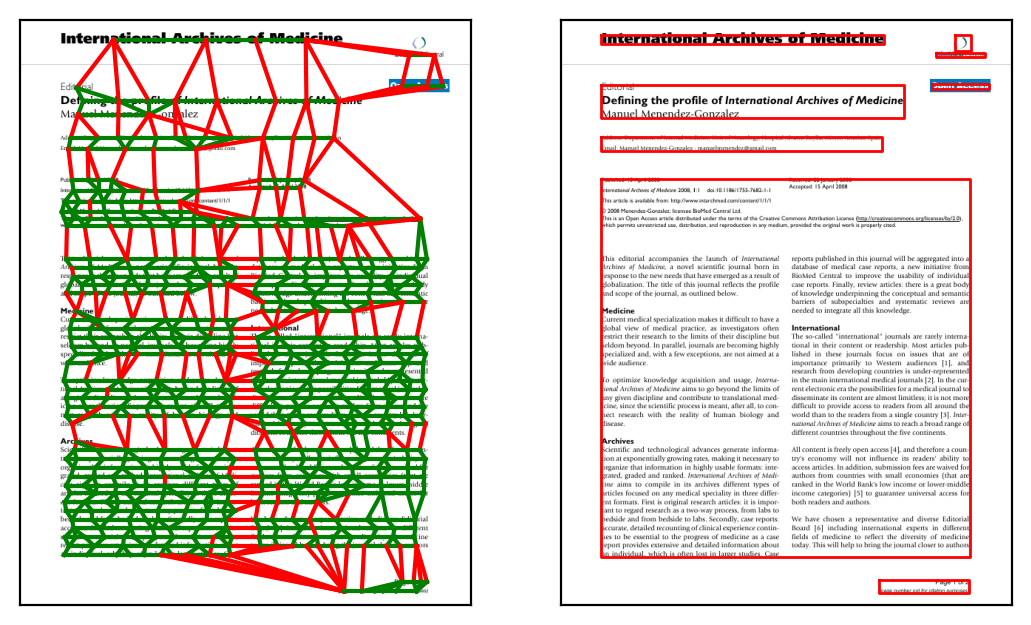

In [43]:
plot_file("./train_files_example/PMC2367690_00000.pdf", class_=False)

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 16


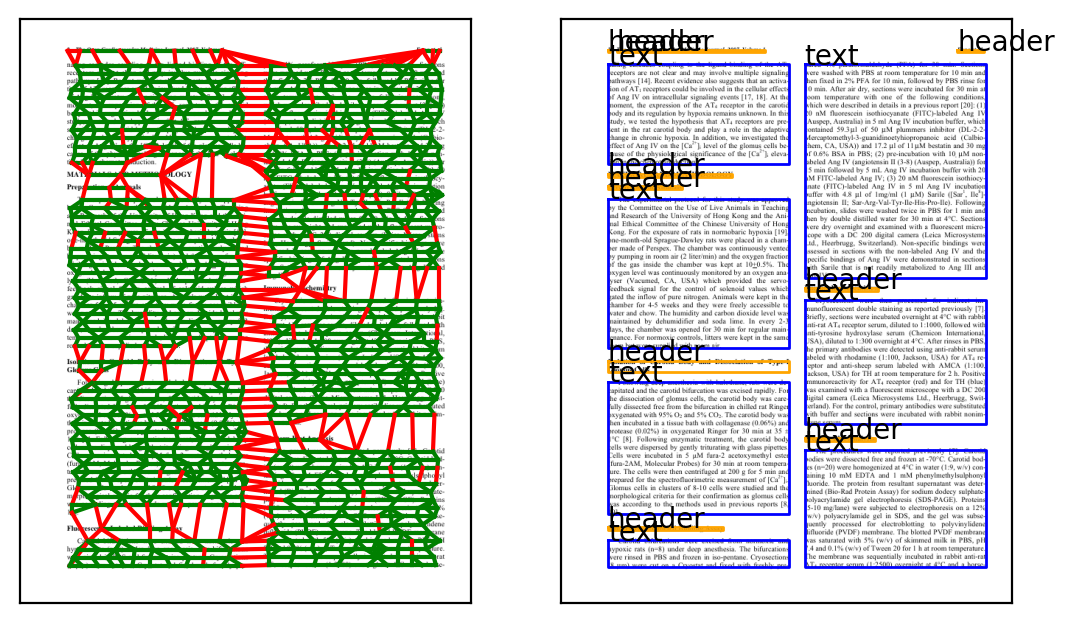

In [44]:
plot_file("./train_files_example/PMC2570565_00001.pdf", class_=True)

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 5


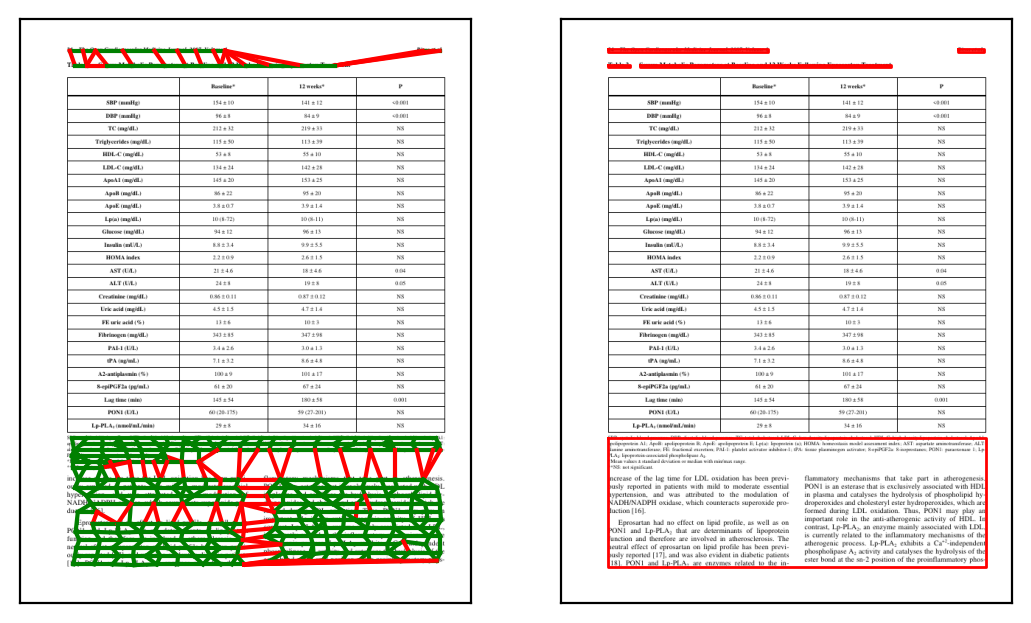

In [45]:
plot_file("./train_files_example/PMC2570567_00002.pdf")

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 13


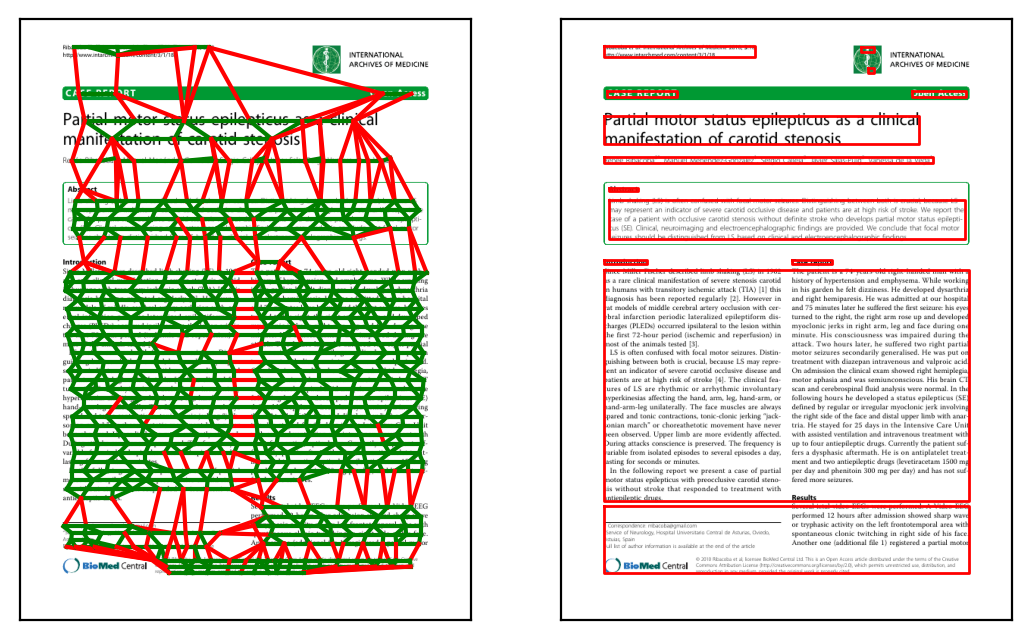

In [46]:
plot_file("./train_files_example/PMC2942812_00000.pdf", class_=False)

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 3


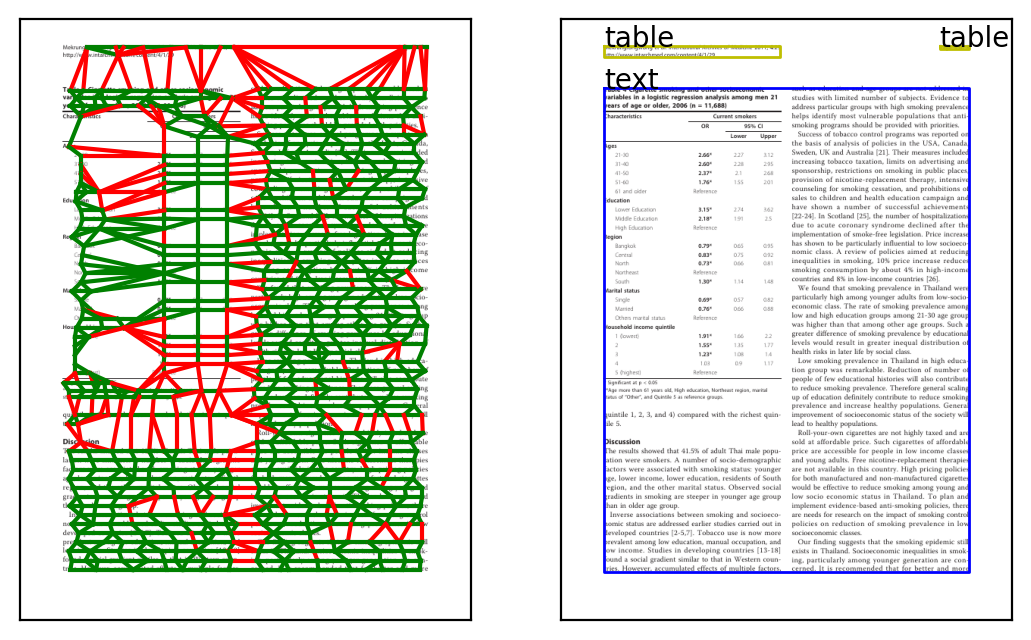

In [47]:
plot_file("./train_files_example/PMC3177771_00004.pdf", class_=True)

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 16


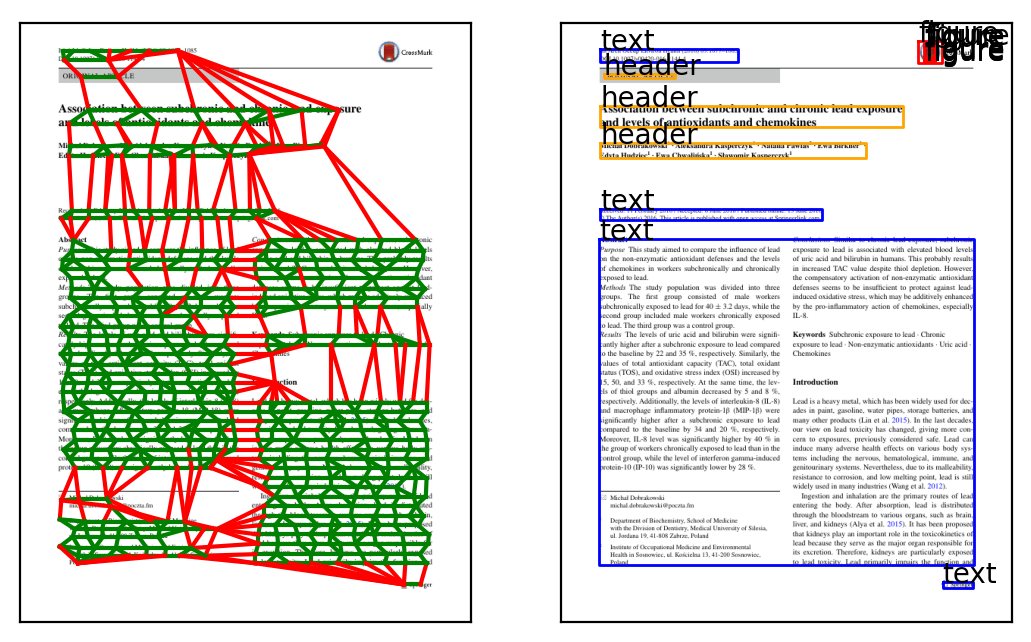

In [48]:
plot_file("./train_files_example/PMC5005401_00000.pdf", class_=True)

count blocks: 8


/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


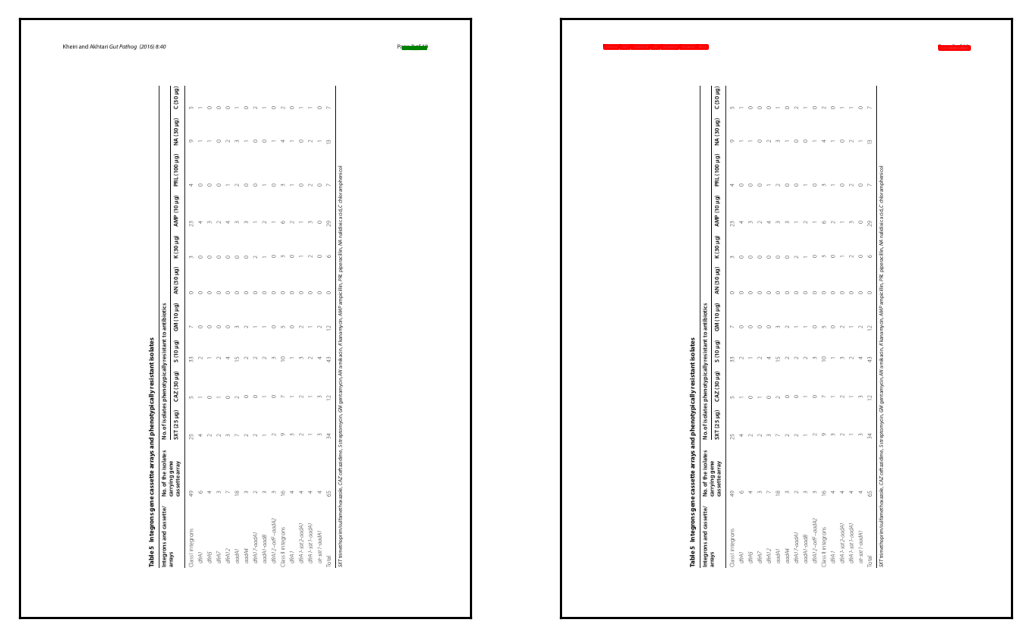

In [15]:
plot_file("./train_files_example/PMC5006490_00006.pdf")

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 4


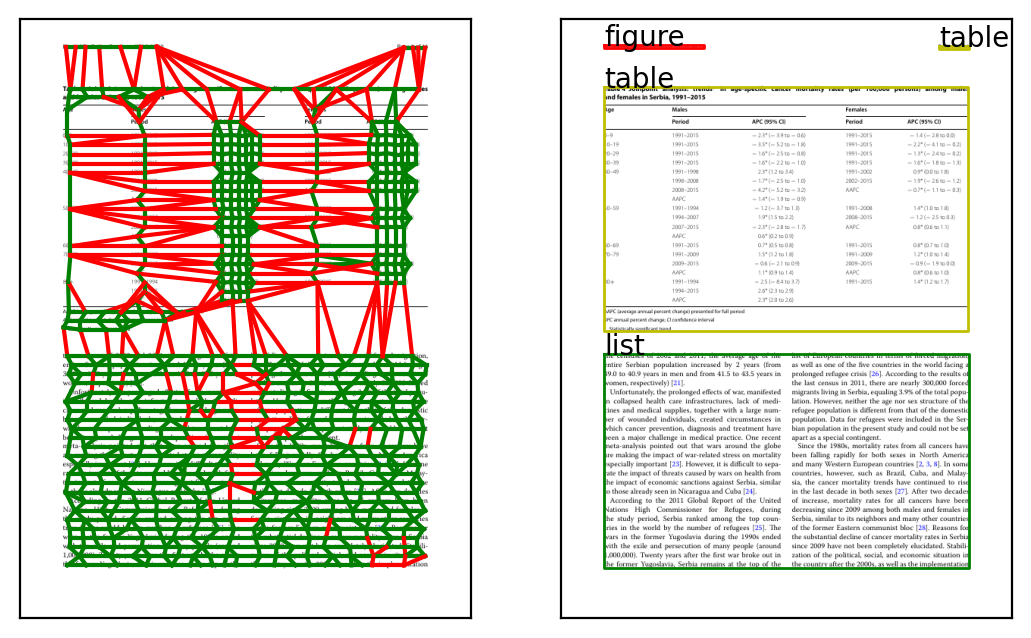

In [16]:
plot_file("./train_files_example/PMC5993142_00007.pdf", class_=True)

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 14


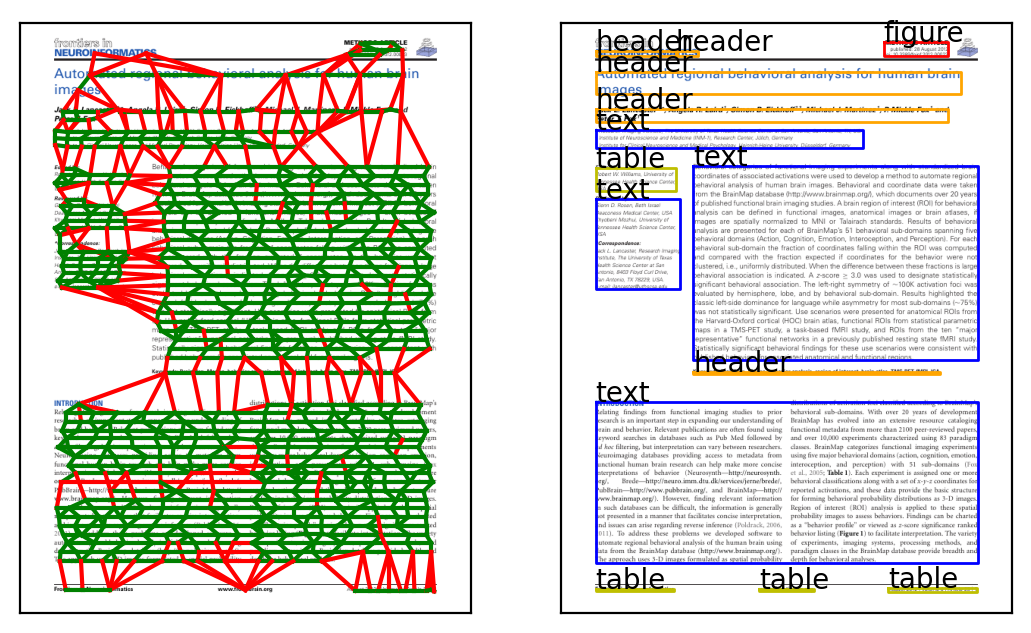

In [49]:
plot_file("./train_files_example/val_files/PMC3428588_00000.pdf", class_=True)

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


count blocks: 2


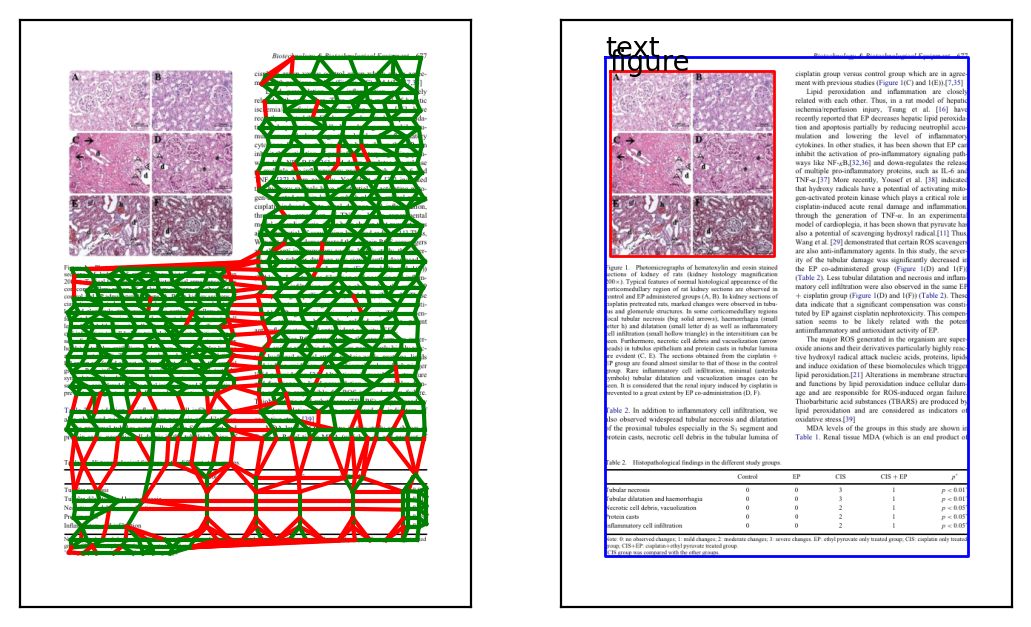

In [50]:
plot_file("./train_files_example/val_files/PMC4433950_00003.pdf", class_=True)